In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sklearn
from sklearn.metrics import classification_report,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GMM, GaussianMixture
from sklearn.cluster import KMeans
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split
%matplotlib inline

In [2]:
#list of sources taken from HST Jordan2006/Peng2008
filename="/Users/lchevalier/Dropbox/Project1_N4526/sextractor/VCC1535_new_complete_colours.fits"
dat_can = Table.read(filename, format='fits')
candidates = dat_can.to_pandas()

#Contamination sources from radial velocity analysis
filename2= '/Users/lchevalier/Dropbox/Project1_N4526/sextractor/N4526_RV_contamin.fits'
dat_conta = Table.read(filename2, format='fits')
contamination = dat_conta.to_pandas()

#File of all point sources extracted from 
filename3 = '/Users/lchevalier/Dropbox/Project1_N4526/sextractor/Subaru_GRI2.fits'
dat_full = Table.read(filename3, format='fits')
full_sample = dat_full.to_pandas()

In [3]:
#fix the table for input 
candidates.rename(columns={'iamag': 'imag', 'gamag': 'gmag', 'ramag': 'rmag','new_RA':'RA','new_Dec':'DEC'}, inplace=True)
cols_keep = ['RA','DEC','imag','rmag','gmag','g_i']
candidates=candidates[cols_keep]
candidates['prob']=1.0
candidates.head()

,RA,DEC,imag,rmag,gmag,g_i,prob
0,188.518029,7.705950,24.566206,24.712036,25.139000,0.572794,1.0
1,188.479568,7.684922,24.446014,24.600886,25.042000,0.595986,1.0
2,188.494488,7.712246,22.945902,23.113293,23.573999,0.628098,1.0
3,188.524715,7.695088,24.382926,24.560054,25.035999,0.653074,1.0
4,188.508799,7.708635,24.119273,24.307183,24.799999,0.680726,1.0


In [150]:
# decide what data to keep an merge into final dataframe
# g, r,i magnitudes, pGC, RA, DEC,ID
contamination.rename(columns={'MAG_APER_3_13': 'imag', 'MAG_APER_1_12': 'gmag', 'MAG_APER_2_14': 'rmag'}, inplace=True)
full_sample.rename(columns={'MAG_APER_3_13': 'imag', 'MAG_APER_1_12': 'gmag', 'MAG_APER_2_14': 'rmag'}, inplace=True)

cols1 = [c for c in contamination.columns if (c.lower()[1:4] == 'mag')]
cols = np.append(cols1,('RA','DEC'))


full_sample= full_sample[cols1]
full_sample['g_i']= full_sample['gmag']-full_sample['imag']
#removing outliers and caping g_i values to physical ones
full_sample = full_sample[(abs(full_sample['g_i'])<2)&(abs(full_sample['gmag'])<26)&(abs(full_sample['imag'])<26)&(abs(full_sample['rmag'])<26)]

contamination = contamination[cols]
contamination['prob']=0.00
contamination['g_i']=contamination['gmag']-contamination['imag']

In [5]:
contamination.head()


,gmag,rmag,imag,RA,DEC,prob,g_i
0,19.750883,18.925962,18.645487,188.497333,7.586472,0.0,1.105396
1,23.363506,22.768564,22.274075,188.494958,7.599528,0.0,1.089432
2,20.976543,19.923868,19.576113,188.411083,7.603333,0.0,1.400431
3,21.996689,21.566404,21.395967,188.502625,7.606028,0.0,0.600721
4,18.829653,18.403706,18.239592,188.450458,7.613417,0.0,0.590061


In [6]:
#combine both datasets for final data catalogue
data = candidates.append(contamination)
data.head()

,DEC,RA,g_i,gmag,imag,prob,rmag
0,7.705950,188.518029,0.572794,25.139000,24.566206,1.0,24.712036
1,7.684922,188.479568,0.595986,25.042000,24.446014,1.0,24.600886
2,7.712246,188.494488,0.628098,23.573999,22.945902,1.0,23.113293
3,7.695088,188.524715,0.653074,25.035999,24.382926,1.0,24.560054
4,7.708635,188.508799,0.680726,24.799999,24.119273,1.0,24.307183


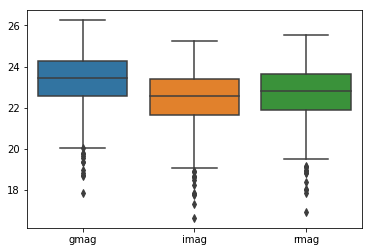

In [76]:
sns.boxplot(data=data[['gmag','imag','rmag']])


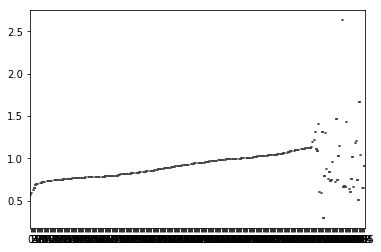

In [78]:
sns.boxplot(data=data['g_i'])

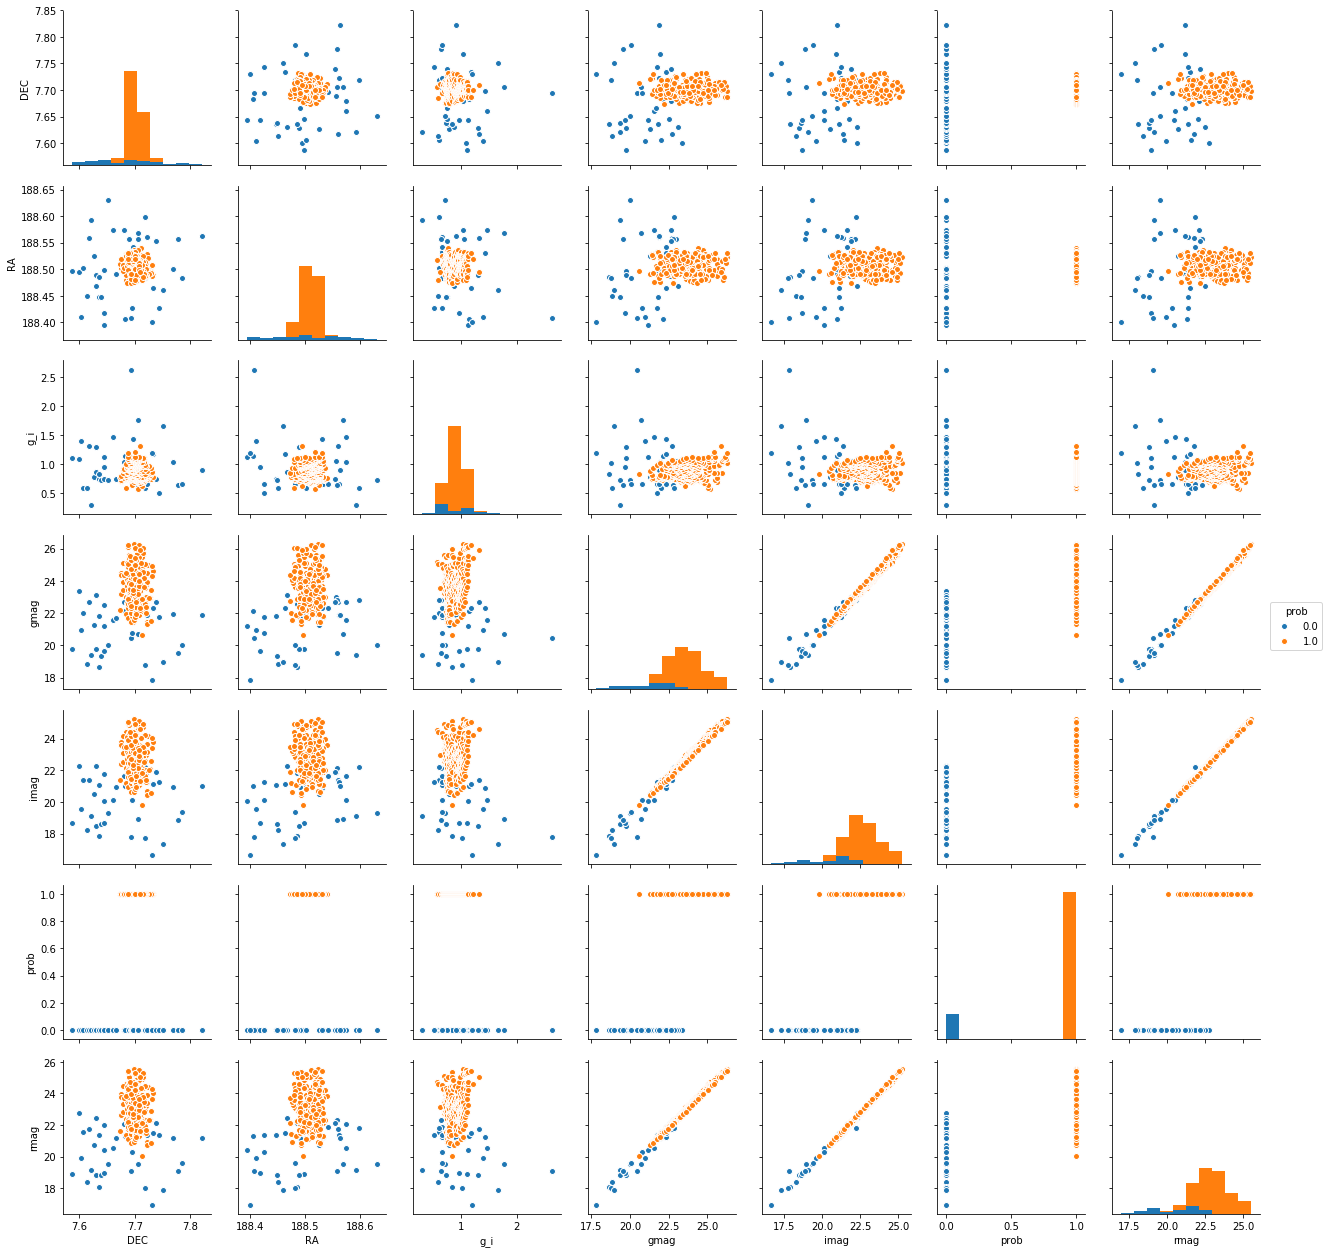

In [9]:
sns.pairplot(data,hue='prob')

# Use unsupervised learning and clustering to deterine groups of blue and red GCs

Text(0.5,0,'g-i [mag]')

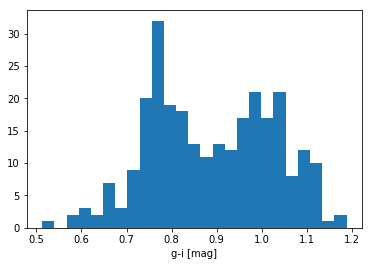

In [140]:
#we only want one axsis to determine the groups
plt.hist(data['g_i'][(data['g_i']<=1.2)&(data['g_i']>=0.4)], bins=25)
plt.xlabel('g-i [mag]')

We see a double peaked profile and therefore try and fit a gaussian mixture model with two components to the dataset

In [141]:
# change so that we purely use g_i by reshaping the array
g_i = np.array(data['g_i'][data['g_i']<=1.5]).reshape(-1,1)
g_i_full = np.array(data['g_i']).reshape(-1,1)
gmm = GaussianMixture(n_components=2,covariance_type='full').fit(g_i)
gmm.predict(g_i_full)
gmm.covariances_

array([[[0.01753841]],

       [[0.01145378]]])

In [142]:
# using a kmeans clustering anlysis instead to determine a blue and a red cluster
kmeans = KMeans(n_clusters=2)
kmeans.fit(g_i)
kmeans.predict(g_i_full)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
      dtype=int32)

In [11]:
data[kmeans.predict(g_i_full)!=gmm.predict(g_i_full)]

,DEC,RA,g_i,gmag,imag,prob,rmag
120,7.697490,188.511023,0.897036,23.858000,22.960964,1.0,23.233207
121,7.678064,188.496697,0.897036,25.076000,24.178964,1.0,24.451207
122,7.700273,188.532633,0.898820,24.322001,23.423180,1.0,23.696119


In [215]:
def gaussian(x, mu, sig, norm=1):
    return (np.exp(-np.power(x - mu, 2.) / (2. * np.power(sig, 2.)))/(np.sqrt(np.pi*2.5)*sig))

def fit_mixture(data,plottingdata, ncomp=2, doplot=False, bins=100, covariance_type='full'):
    
    
    clf = GaussianMixture(n_components=ncomp, covariance_type=covariance_type)
    clf.fit(data)
    ml = clf.means_
    wl = clf.weights_
    cl = clf.covariances_
    means = [m[0] for m in ml]
    weights = [w for w in wl]
    colours= ['b', 'r', 'g', 'y']
    col =[]
    if covariance_type =='full':
        st_devs = [np.sqrt(c[0][0]) for c in cl]
    elif covariance_type =='diag':
        st_devs = [np.sqrt(c[0]) for c in cl]
    elif covariance_type =='spherical':
        st_devs=[np.sqrt(c) for c in cl]
    #print col
    for i in np.arange(0,ncomp,1):
        col.append(colours[i])
    if doplot == True:
        histo = plt.hist(plottingdata, bins, density=True, color='black', histtype='step')
        print (histo[1])
        # plotting should be normalised so that there 
        #is no longer a problem with the normalised gaussians
        for w, m, c, cl in zip(weights, means, st_devs, col):
            cover= np.arange(min(histo[1]),max(histo[1]),0.001)
            plt.plot(cover,gaussian(cover,m,c), linewidth=3, color = cl)
    return means, st_devs, weights

[0.29684448 0.3435231  0.39020172 0.43688034 0.48355896 0.53023758
 0.5769162  0.62359482 0.67027344 0.71695206 0.76363068 0.8103093
 0.85698792 0.90366653 0.95034515 0.99702377 1.04370239 1.09038101
 1.13705963 1.18373825 1.23041687 1.27709549 1.32377411 1.37045273
 1.41713135 1.46380997 1.51048859 1.55716721 1.60384583 1.65052444
 1.69720306 1.74388168 1.7905603  1.83723892 1.88391754 1.93059616
 1.97727478 2.0239534  2.07063202 2.11731064 2.16398926 2.21066788
 2.2573465  2.30402512 2.35070374 2.39738235 2.44406097 2.49073959
 2.53741821 2.58409683 2.63077545]


(0.4, 1.3)

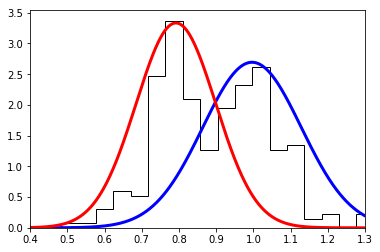

In [216]:
fit_mixture(g_i,plottingdata= data['g_i'], doplot= True, bins=50, covariance_type='full')
plt.xlim(0.4,1.3)

In [156]:
hist =np.array([0.29684448,0.37469838,0.45255229,0.53040619,0.60826009,0.68611399,0.7639679 , 0.8418218 , 0.9196757 , 0.9975296 , 1.0753835 , 1.15323741,1.23109131, 1.30894521 ,1.38679911, 1.46465302])
cover= np.arange(min(hist),max(hist),0.001)
print (cover)

[0.29684448 0.29784448 0.29884448 ... 1.46184448 1.46284448 1.46384448]


# Use magnitudes to predict GC probability values
for both the original training set and then the full sample of GCs

In [70]:
# write classifier that determines whether or not something is a GC or not
# using logistic regression rather then a KNN algorithem
#don't need to create dummy variables as data['prob'] is already in the correct format

y = data['prob']
X = data[['g_i','rmag','RA','DEC']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))




             precision    recall  f1-score   support

        0.0       1.00      0.43      0.61        23
        1.0       0.90      1.00      0.95       120

avg / total       0.92      0.91      0.89       143



[0.99638198 0.98924832 0.85238826 0.96218507 0.93679234 0.62575037
 0.99423504 0.93706057 0.98079155 0.09693954 0.89443493 0.8562101
 0.97792405 0.9653456  0.79935417 0.98762765 0.98598622 0.99661037
 0.78671724 0.93054439 0.96784047 0.98907137 0.96754301 0.95114829
 0.99558303 0.53618251 0.96698433 0.84649295 0.99265475 0.99171581
 0.90321022 0.95894357 0.97270933 0.53061042 0.99351907 0.97395097
 0.84359245 0.71101953 0.91499289 0.97657238 0.97395231 0.98499614
 0.97589187 0.90100843 0.99928048 0.96017061 0.9993315  0.94320962
 0.87923537 0.50562555 0.99295612 0.97624431 0.963827   0.01785266
 0.98658942 0.79958386 0.99663761 0.99950129 0.07063145 0.98470078
 0.99516403 0.89806821 0.99914759 0.98218689 0.81185654 0.72173807
 0.68570826 0.98744176 0.53732421 0.02771376 0.83514801 0.99914826
 0.96409911 0.91899254 0.99895859 0.96182214 0.99935346 0.62764553
 0.70133401 0.00798122 0.83105873 0.69469449 0.99509272 0.90877384
 0.93465153 0.98766681 0.99726792 0.90294156 0.95316101 0.97069

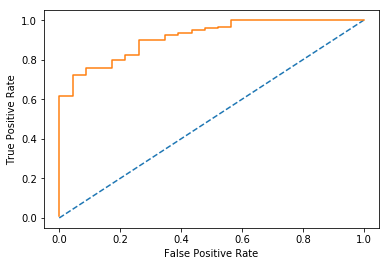

In [71]:
y_predict_prob = logreg.predict_proba(X_test)[:,1]
print (y_predict_prob)

# generating the false positive rate, true positive rate as well as threshholds
fpr, tpr, threshholds = roc_curve(y_test, y_predict_prob)


plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Model application to previously unseen data

No longer split into training and testing data
take out RA and DEC as the new model doesn't represent the old one in shape


In [151]:
X_new = full_sample[['g_i','rmag']]#.reshape(-1,1)

#retrain model


logreg.fit(X[['g_i','rmag']],y)#.reshape(-1,1),y)

y_pred_full = logreg.predict(X_new)

full_sample['prob']=y_pred_full



In [152]:
print(full_sample['prob'].unique())

print(len(full_sample[full_sample['prob']==1]))

[1. 0.]
27636


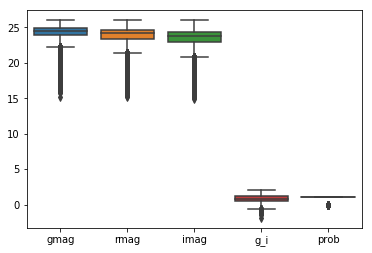

In [153]:
sns.boxplot(data=full_sample)

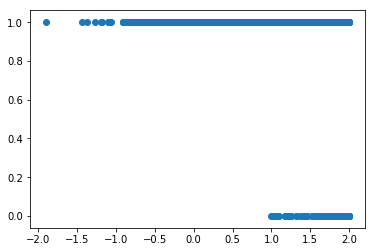

In [154]:
plt.scatter(full_sample['g_i'],full_sample['prob'])

(array([1.000e+00, 5.000e+00, 2.000e+01, 1.140e+02, 1.360e+03, 5.526e+03,
        7.357e+03, 7.863e+03, 3.815e+03, 1.575e+03]),
 array([-1.90407944, -1.51367474, -1.12327003, -0.73286533, -0.34246063,
         0.04794407,  0.43834877,  0.82875347,  1.21915817,  1.60956287,
         1.99996758]),
 <a list of 10 Patch objects>)

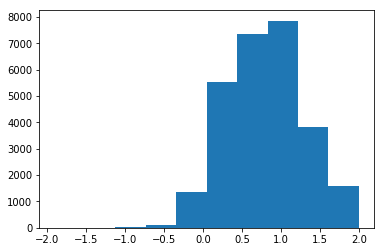

In [155]:
plt.hist(full_sample['g_i'][full_sample['prob']==1])